# Working with Uganda Dataset

## Name: Victor Agaba

## Date: 2024-08-12

***

In [1]:
import numpy as np
from numpy import linalg
import pandas as pd
import functions as fn
import seismic_model as sm
import optimizer as opt
import beachplot as bp
from matplotlib import pyplot as plt
from obspy.taup import TauPyModel
import importlib

***
#### Data Preprocessing
***

In [2]:
# read uganda_data.csv
data = pd.read_csv('ug_data.csv', header=0)
data = data.replace(np.nan, '', regex=True)

# shift errors to their own columns
amp_types = ['Raw', 'LP', 'BP']
og_cols = []
error_cols = []
for col in data.columns:
    for amp_type in amp_types:
        if amp_type in col:
            og_cols.append(col)
            error_cols.append(f'{col} error')

for col in error_cols:
    data[col] = np.nan

for i in range(1, len(data), 2):
    for j in range(len(og_cols)):
        data.at[i, error_cols[j]] = data.at[i-1, og_cols[j]]

data = data.drop(data.index[::2])
data.index = range(len(data))

# print(data.head())
print(data.iloc[:, :15].head())

  Item    Event Id Magnitude      Origin time Longitude Latitude Depth  \
0  8.0  usp000a8sp       4.9  1/31/2001 19:15    29.494    0.466  27.7   
1  7.0  usp000hx9x       5.0   3/15/2011 3:25    31.231    1.746  10.0   
2  6.0  usb000i4t5       5.2   7/2/2013 13:33    30.907    1.606  10.0   
3  5.0  usb000i67t       5.7   7/3/2013 19:21    30.894    1.537  10.1   
4  4.0  usb000i6hl       5.1   7/3/2013 22:22    30.818    1.548  10.0   

  Station Location Azimuth: BHR Azimuth: BHT Rotation Takeoff: Pn Takeoff: Sn  \
0    MBAR   Uganda        129.0        219.0   Normal       53.86       56.93   
1    KMBO      DRC        115.0        205.0   Normal       45.94       48.48   
2    MBAR   Uganda        186.0        276.0   Normal       45.94       48.48   
3    MBAR   Uganda        184.0        274.0   Normal       45.94       48.48   
4    MBAR   Uganda        185.0        275.0   Normal       45.94       48.48   

  Inc Angle: Pn  
0         45.84  
1         45.84  
2         45.8

***
#### Source Mechanism
***

In [3]:
idx = 0
az_type = 'BHR'
azimuth = data.iloc[idx][f'Azimuth: {az_type}']
wave_types = ['P', 'S']
takeoff_angles = [data.iloc[idx][f'Takeoff: {wave_type}n'] for wave_type in wave_types]
velocities = np.array([5.80, 3.46])

# need to correct for measurement stuff
amp_type = 'Raw'
amps = ['P', 'SV', 'SH']
Ao = np.array([data.iloc[idx][f'{amp_type}: {amp}'] for amp in amps])
Uo = np.array([data.iloc[idx][f'{amp_type}: {amp} error'] for amp in amps])

***
#### Hybrid Inversion
***

In [5]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)
importlib.reload(bp)

# initialize model
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
inv_model.set_Ao(Ao)


# tune hyperparameters
config = opt.get_config()

# initialize random hybrid search: many runs
num_runs = 100
starts = fn.random_params(num_runs)

# # initialize systematic hybrid search: debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_runs = len(starts)

# multi-start optimization
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.convergence_rate():.0f}%')

Run 0 of 100
Run 10 of 100
Run 20 of 100
Run 30 of 100
Run 40 of 100
Run 50 of 100
Run 60 of 100
Run 70 of 100
Run 80 of 100
Run 90 of 100
Convergence rate: 93%


Axis: T
Optimal parameters: [187.33461305  51.19709079  13.33718641]
Search error: 0.5048964625443242 degrees


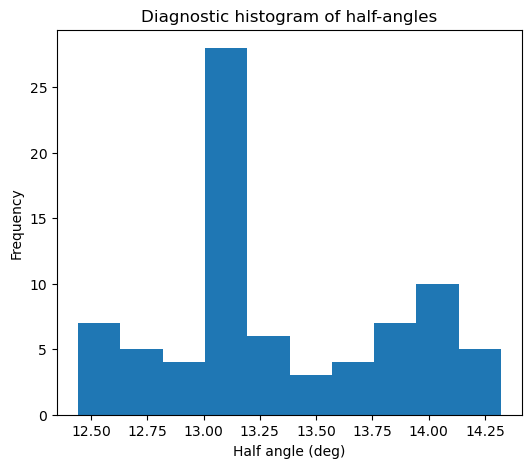

In [6]:
params, error, position = inv_model.optimal_parameterization()
name = 'T' if position == 0 else 'P'

print(f'Axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

inv_model.plot_half_angles(bins=10)

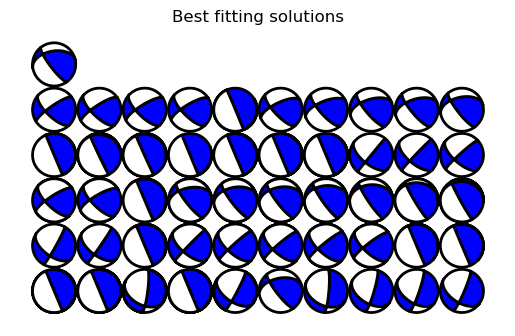

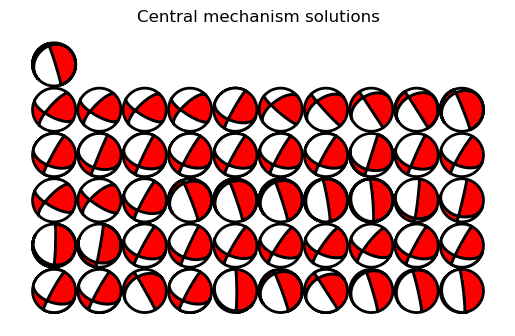

In [7]:
# beachball plots
inv_model.plot_beachballs(central=False, order_by='strike')
inv_model.plot_beachballs(central=True, order_by='strike')

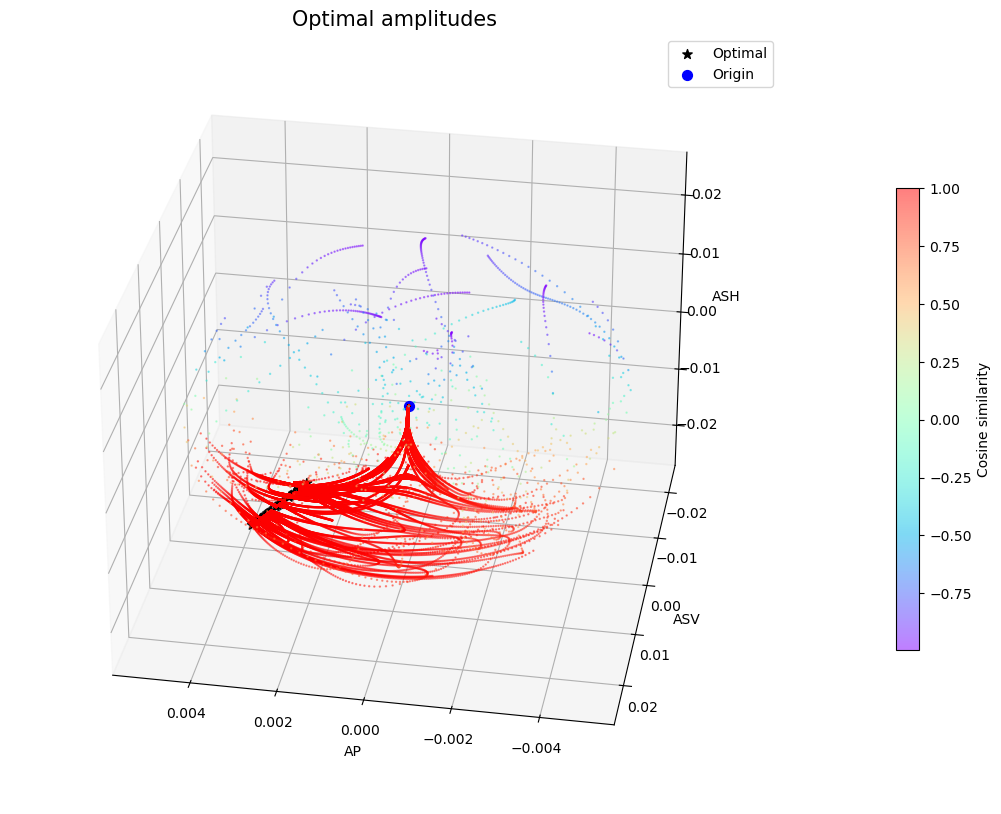

In [8]:
# amplitude plot
inv_model.plot_amplitudes(azim=100, elev=30, s=50, alpha=0.5, iterates=True, observed=False)

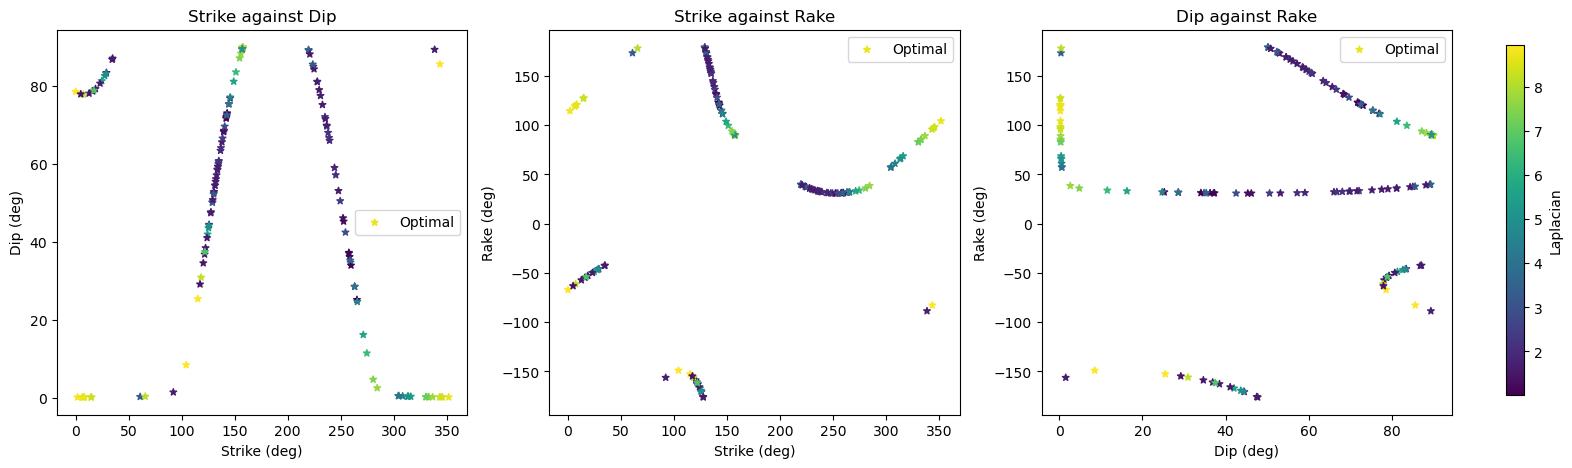

In [9]:
# iterate plot - sdr space
inv_model.plot_iterates_2D(s=25, optimal=True, index=2, cmap='viridis')
# inv_model.plot_iterates_2D(s=1, optimal=False, index=0)
# inv_model.plot_iterates_2D(s=1, optimal=False, index=1)

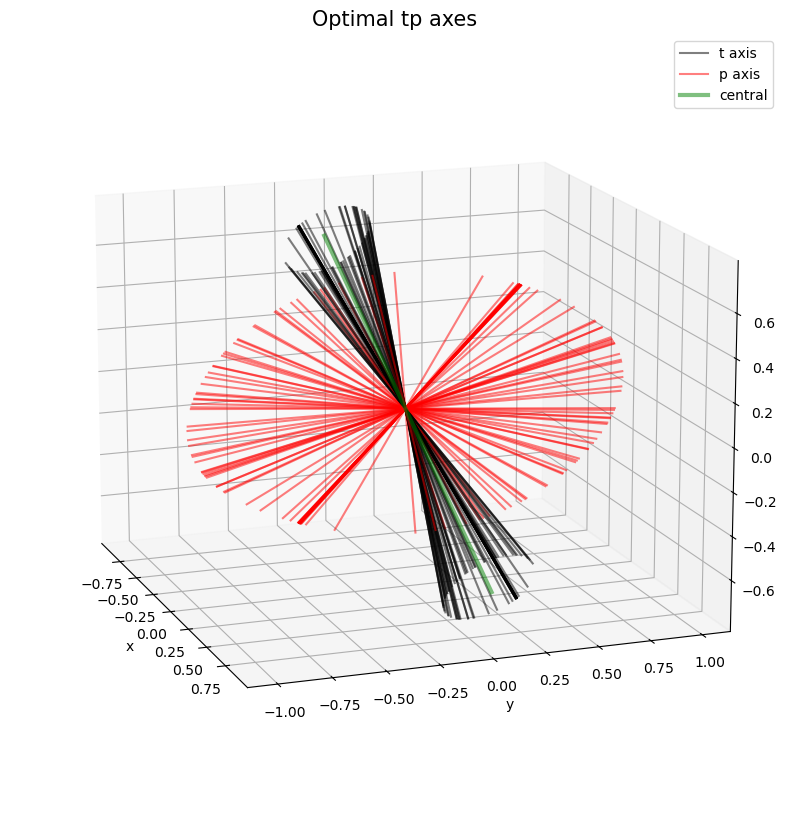

In [10]:
# optimal plot - tp space, collapse to central
inv_model.plot_tp_axes(azim=-20, elev=15, half=False, central=False)

***
#### Uncertainty Propagation
***

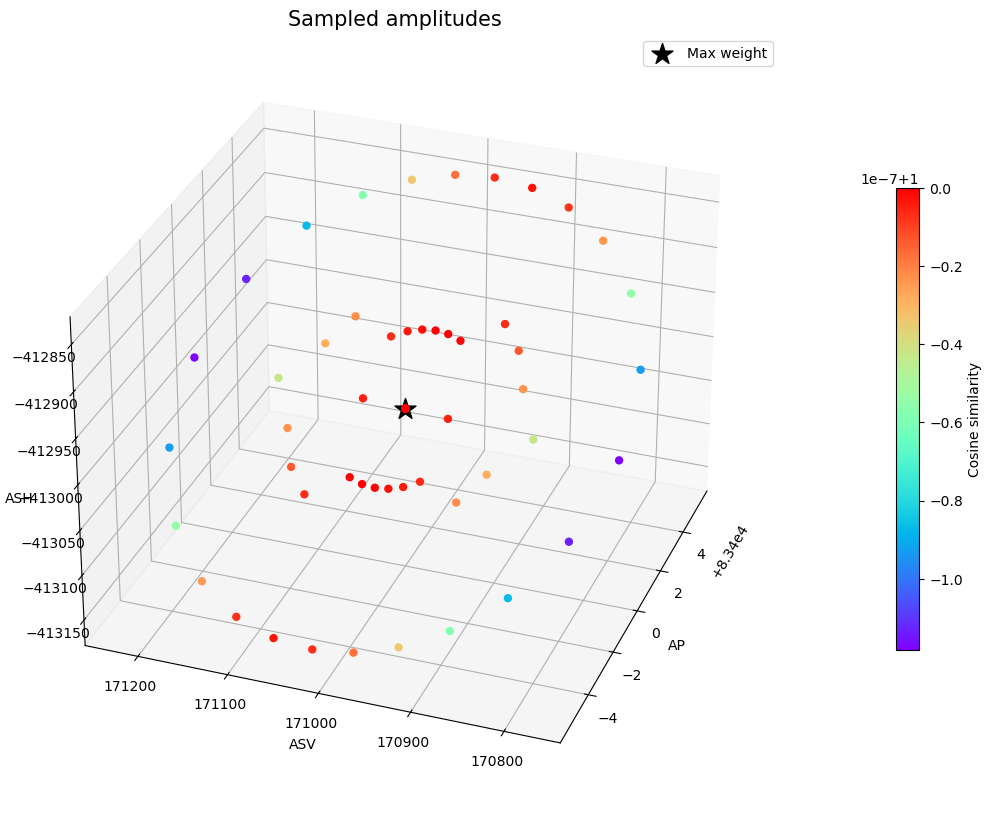

In [118]:
dd, num_samples = 15, 50
# dd, num_samples = 30, 15  # debugging
inv_model.set_Uo(Uo)
inv_model.set_chi2()
inv_model.sample_amplitudes(dd, num_samples)
inv_model.plot_sampled_amplitudes(cmap='rainbow', s=25, azimuth=200, elevation=30)

In [119]:
num_runs, print_every = 30, 0
inv_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 55
Sample 1 of 55
Sample 2 of 55
Sample 3 of 55
Sample 4 of 55
Sample 5 of 55
Sample 6 of 55
Sample 7 of 55
Sample 8 of 55
Sample 9 of 55
Sample 10 of 55
Sample 11 of 55
Sample 12 of 55
Sample 13 of 55
Sample 14 of 55
Sample 15 of 55
Sample 16 of 55
Sample 17 of 55
Sample 18 of 55
Sample 19 of 55
Sample 20 of 55
Sample 21 of 55
Sample 22 of 55
Sample 23 of 55
Sample 24 of 55
Sample 25 of 55
Sample 26 of 55
Sample 27 of 55
Sample 28 of 55
Sample 29 of 55
Sample 30 of 55
Sample 31 of 55
Sample 32 of 55
Sample 33 of 55
Sample 34 of 55
Sample 35 of 55
Sample 36 of 55
Sample 37 of 55
Sample 38 of 55
Sample 39 of 55
Sample 40 of 55
Sample 41 of 55
Sample 42 of 55
Sample 43 of 55
Sample 44 of 55
Sample 45 of 55
Sample 46 of 55
Sample 47 of 55
Sample 48 of 55
Sample 49 of 55
Sample 50 of 55
Sample 51 of 55
Sample 52 of 55
Sample 53 of 55
Sample 54 of 55


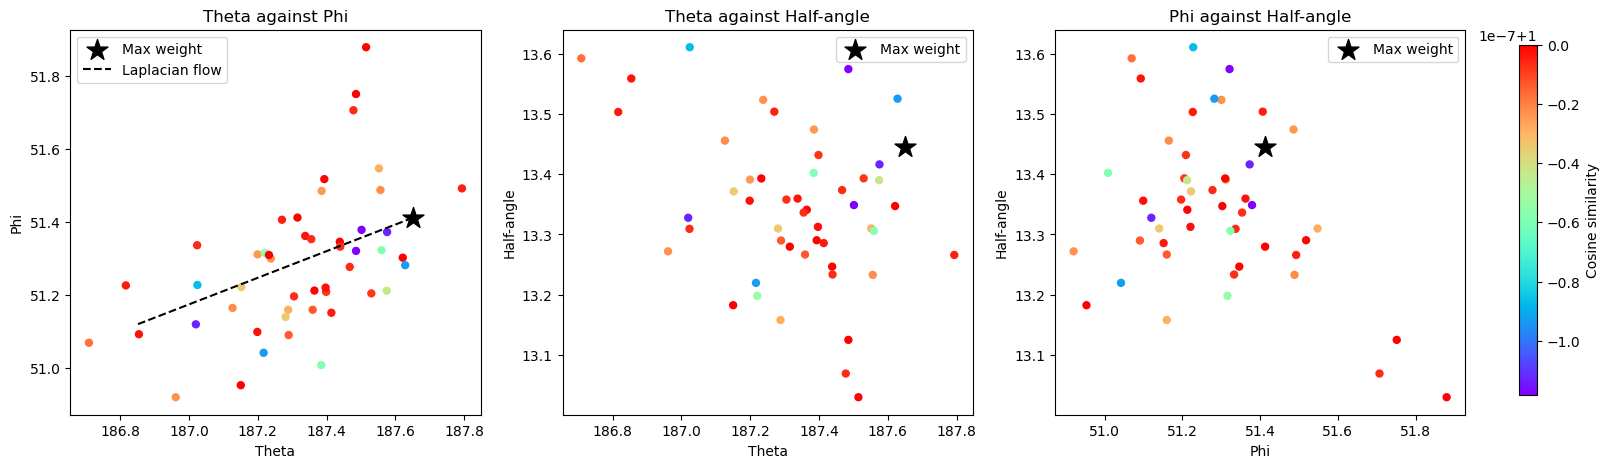

In [133]:
# monte carlo plot - cone space
error_threshold = 5
inv_model.post_filter(threshold=error_threshold)
inv_model.plot_uncertainty_2D(s=25, scale=-0.015)
# inv_model.plot_uncertainty_3D(elev=30, azim=45, s=25)

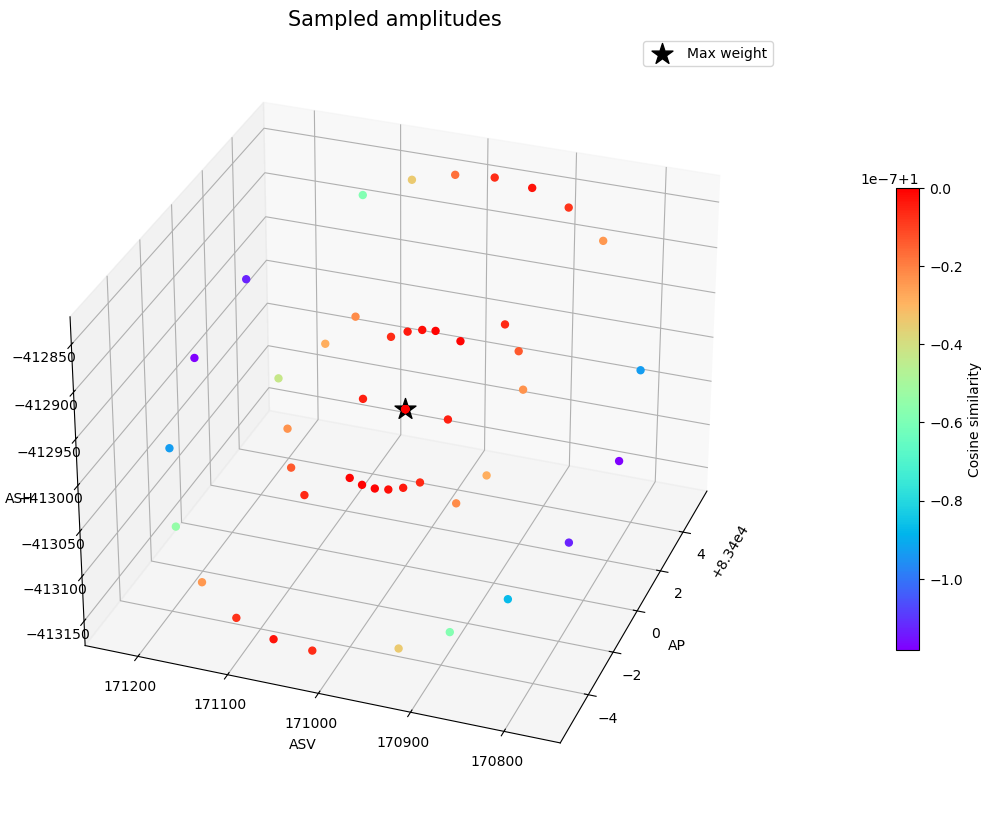

In [123]:
inv_model.plot_sampled_amplitudes(cmap='rainbow', s=25, azimuth=200, elevation=30)

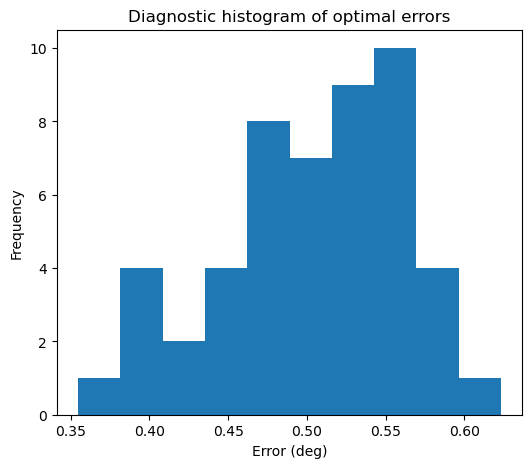

In [122]:
# diagnostic plot of monte carlo errors
inv_model.plot_optimal_errors(bins=10)

***
INSIGHTS:
* For very small errors, we can still approximate a covariance ellipse using PCA
* Laplacian generally points away from the transformation's center of mass
* Include alpha level on uncertainty plot (perhaps split by mode)
* See if the central mechanisms are really Kagan angles
* The modes are begging to show on a continuum!
* Observations are so much bigger than simulations for idx=0

***